In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import register_matplotlib_converters
from   pprint import pprint

register_matplotlib_converters()
%matplotlib inline

In [2]:
#!open ../data/sp1950.csv

In [3]:
sp = pd.read_csv('../data/sp1950.csv')
sp = sp[['Date', 'Open', 'Close', 'Adj Close']]
sp = sp.rename(columns={'Adj Close': 'Value'})
sp.head()

,Date,Open,Close,Value
0,1/3/50,16.66,16.66,16.66
1,1/4/50,16.85,16.85,16.85
2,1/5/50,16.93,16.93,16.93
3,1/6/50,16.98,16.98,16.98
4,1/9/50,17.08,17.08,17.08


In [4]:
sp.tail()

,Date,Open,Close,Value
17716,5/29/20,2861.280029,3029.73,3029.73
17717,6/1/20,2861.280029,3055.73,3055.73
17718,6/2/20,2861.280029,3080.82,3080.82
17719,6/3/20,2861.280029,3122.87,3122.87
17720,6/4/20,2861.280029,3112.35,3112.35


In [5]:
def date2datetime(date):
    month, day, year = date.split('/')
    if int(year) > 20:
        year = int(year) + 1900
    else:
        year = int(year) + 2000
    try:
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        print(date)

In [6]:
date2datetime('1/3/50')

Timestamp('1950-01-03 00:00:00')

In [7]:
sp.Date = sp.Date.apply(date2datetime)
sp.head()

,Date,Open,Close,Value
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


In [8]:
sp['ChangeSinceOpen'] = sp['Close'] / sp['Open']
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen
17716,2020-05-29,2861.280029,3029.73,3029.73,1.058872
17717,2020-06-01,2861.280029,3055.73,3055.73,1.067959
17718,2020-06-02,2861.280029,3080.82,3080.82,1.076728
17719,2020-06-03,2861.280029,3122.87,3122.87,1.091424
17720,2020-06-04,2861.280029,3112.35,3112.35,1.087747


In [9]:
sp['DailyChange'] = np.nan
sp['OvernightChange'] = np.nan
for day in range(1, sp.shape[0]):
    sp.loc[day, 'DailyChange'] = (sp.loc[day, 'Value'] 
                                  / sp.loc[day - 1, 'Value'])
    sp.loc[day, 'OvernightChange'] = (sp.loc[day, 'Open'] 
                                      / sp.loc[day - 1, 'Close'])
sp.tail()        

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange
17716,2020-05-29,2861.280029,3029.73,3029.73,1.058872,1.000000,0.944401
17717,2020-06-01,2861.280029,3055.73,3055.73,1.067959,1.008582,0.944401
17718,2020-06-02,2861.280029,3080.82,3080.82,1.076728,1.008211,0.936365
17719,2020-06-03,2861.280029,3122.87,3122.87,1.091424,1.013649,0.928740
17720,2020-06-04,2861.280029,3112.35,3112.35,1.087747,0.996631,0.916234


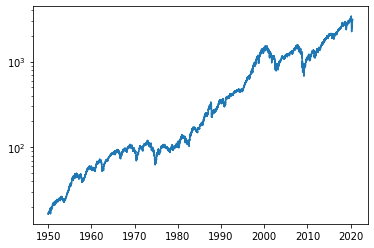

In [10]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

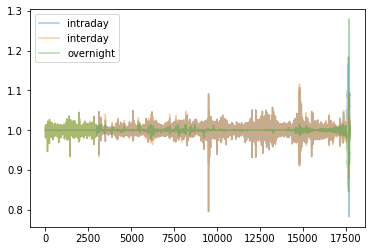

In [11]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

In [12]:
sp = sp.loc[3014:, :]
sp.index = range(sp.shape[0])

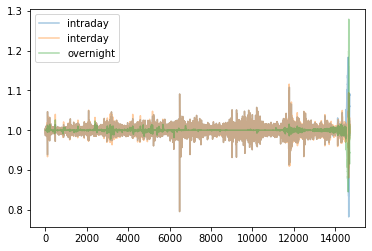

In [13]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

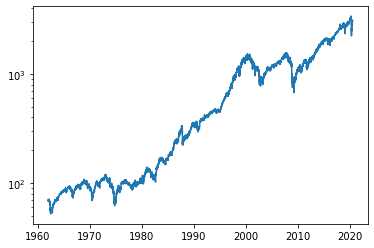

In [14]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

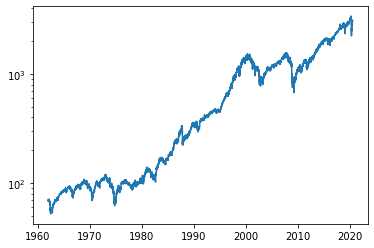

In [15]:
START_DATE = pd.to_datetime('1962-01-01')
sp = sp.loc[sp.Date >= START_DATE, :]
sp.index = range(sp.shape[0])
plt.plot(sp.Date, sp.Value)
plt.yscale('log');

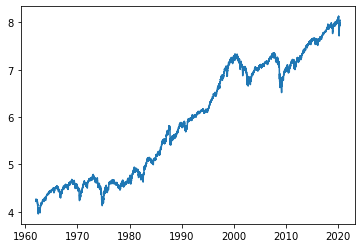

In [16]:
plt.plot(sp.Date, np.log(sp.Value));

In [17]:
sp.Value = np.log(sp.Value)

In [18]:
def moving_dev_signals(x, params):
    '''
    @params
    x: list: time series of quantiles (relative to an arbitrary window)
    params: dictionary 
      {'qs': [<np.array of quantiles>], 
       'amounts': [<np.array of amounts>]}
    qs: lists<float>: quantiles for which, moving upward/downward 
        across signals an action. A + value indicate an upward movement; -
        for downward movement.
    amounts: lists<float>: amount (%) to put in (+) or take out (-)
        associated with each signal in <qs>
    @return: array of signals (usually just one, but multiple events may
        occur on a single day)
    '''
    qs = params['qs']
    amounts = params['amounts']
    assert len(qs) == len(amounts), 'qs and amounts of different lengths'
    up_qs = qs[qs >= 0]
    down_qs = -qs[qs < 0]
    up_amounts = amounts[qs >= 0]
    down_amounts = amounts[qs < 0]
    x = x.tolist()
    n = len(x)
    up_qs = np.quantile(x, up_qs)
    down_qs = np.quantile(x, down_qs)
    signals = []
    for q, action in zip(up_qs, up_amounts):
        if x[n - 2] < q and x[n - 1] > q:
            signals.append(action)
    for q, action in zip(down_qs, down_amounts):
        if x[n - 2] > q and x[n - 1] < q:
            signals.append(action)
    return signals if signals else [0]

In [19]:
def get_devs_relative_to_trend(sp, ma_window):
    ma = np.log(sp.loc[:, 'Value']).rolling(window=ma_window).mean()
    sp['difference'] = np.log(sp['Value']) - ma
    n = sp.shape[0]
    qs = list(np.linspace(1, 0, n))
    x = [0] * n
    for i in sp.sort_values('difference').index:
        x[i] = qs.pop()
    return x

In [20]:
def generate_actions(sp, window, params):
    '''
    Given a <window> to calculate the MA over, and <params> for 
    <moving_dev_signals()>, return <sp> with an <Actions> field appended, 
    each value for which should be a list of actions (%s in out) each day,
    based on the signal(s) that occurred each day.
    '''
    qs = np.array(params['qs'])
    amounts = np.array(params['amounts'])
    assert len(qs) == len(amounts), 'qs and amounts of different lengths'
    sp['q'] = get_devs_relative_to_trend(sp, window)
    up_qs = qs[qs >= 0]
    down_qs = -qs[qs < 0]
    up_amounts = amounts[qs >= 0]
    down_amounts = amounts[qs < 0]
    x = sp.q
    n = len(x)
    sp.index = range(n)
    sp['Actions'] = pd.Series([[0] for i in range(n)])
    for i in range(window, n):
        signals = []
        for q, action in zip(up_qs, up_amounts):
            if x[i - 2] < q and x[i - 1] >= q:
                signals.append(action)
        for q, action in zip(down_qs, down_amounts):
            if x[i - 2] >= q and x[i - 1] < q:
                signals.append(action)
        signals = signals or [0]
        try:
            sp.at[i, 'Actions'] = signals
        except BaseException as e:
            print(e)
            print(sp.at[i, 'Actions'], '<-', signals)
            return(sp)
    return sp

In [21]:
test = generate_actions(
    sp, 100, {'qs': [-0.4, 0.6], 'amounts': [1, -0.5]})
test.tail(10)

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,difference,q,Actions
14697,2020-05-21,2861.280029,2948.51,7.989055,1.030486,0.992226,0.962872,-0.000198,0.326261,[0]
14698,2020-05-22,2861.280029,2955.45,7.991406,1.032912,1.002354,0.970416,0.000207,0.341629,[0]
14699,2020-05-26,2861.280029,2991.77,8.003620,1.045605,1.012289,0.968137,0.001840,0.424181,[0]
14700,2020-05-27,2861.280029,3036.13,8.018339,1.061109,1.014827,0.956384,0.003756,0.532368,[0]
14701,2020-05-28,2861.280029,3029.73,8.016229,1.058872,0.997892,0.942410,0.003579,0.521148,[0]
14702,2020-05-29,2861.280029,3029.73,8.016229,1.058872,1.000000,0.944401,0.003661,0.526452,[0]
14703,2020-06-01,2861.280029,3055.73,8.024774,1.067959,1.008582,0.944401,0.004804,0.593295,[0]
14704,2020-06-02,2861.280029,3080.82,8.032951,1.076728,1.008211,0.936365,0.005898,0.657419,[0]
14705,2020-06-03,2861.280029,3122.87,8.046508,1.091424,1.013649,0.928740,0.007640,0.737930,[-0.5]
14706,2020-06-04,2861.280029,3112.35,8.043133,1.087747,0.996631,0.916234,0.007288,0.721542,[0]


In [22]:
init_amount = sp.Close[0]
init_amount

71.129997

In [23]:
sp['Reserve'] = np.nan
sp['Invested'] = np.nan
sp.loc[0, 'Reserve'] = init_amount
sp.loc[0, 'Invested'] = 0.
sp.head()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,difference,q,Actions,Reserve,Invested
0,1962-01-03,70.959999,71.129997,4.264509,1.002396,1.002396,1.0,NaN,0.993336,[0],71.129997,0.0
1,1962-01-04,71.129997,70.639999,4.257597,0.993111,0.993111,1.0,NaN,0.993404,[0],NaN,NaN
2,1962-01-05,70.639999,69.660004,4.243626,0.986127,0.986127,1.0,NaN,0.993472,[0],NaN,NaN
3,1962-01-08,69.660004,69.120003,4.235844,0.992248,0.992248,1.0,NaN,0.993540,[0],NaN,NaN
4,1962-01-09,69.120003,69.150002,4.236278,1.000434,1.000434,1.0,NaN,0.993608,[0],NaN,NaN


In [24]:
def update_values(row):
    reserve = row['Reserve']
    invested = row['Invested']
    change_since_open = row['ChangeSinceOpen']
    overnight_change = row['OvernightChange']
    invested *= overnight_change
    money_per_action = 0
    for action in row['Actions']:
        if action > 0: # Buy
            money_per_action = reserve * action
        if action < 0: # Sell
            money_per_action = invested * action    
        reserve -= money_per_action
        invested += money_per_action
    invested *= change_since_open
    return reserve, invested

In [25]:
def predict_performance(sp):
    for day in range(1, sp.shape[0]):
        sp.loc[day, ['Reserve', 'Invested']] = sp.loc[
            day - 1, ['Reserve', 'Invested']]
        sp.loc[day, ['Reserve', 'Invested']] = update_values(
            sp.loc[day, :])
        sp['Total'] = sp['Reserve'] + sp['Invested']
    return sp

In [26]:
def print_params(params, window):
    print('window:', window)
    print('params:')
    pprint(params)

In [27]:
def trunc_normal(mean, sd, minval, maxval, exclude0=False):
    val = np.random.normal(mean, scale=sd)
    val = max(min(val, maxval), minval)
    if exclude0:
        if -0.01 < val <= 0:
            val = -0.01
        elif 0 <= val < 0.01:
            val = 0.01
    return val

In [28]:
def init_values(sd, init_window, init_params, min_window=40, mindiff=0.05):    
    window = int(round(
            trunc_normal(init_window, 400*sd, min_window, 1000)))
    params = {'qs': [trunc_normal(mean, sd, -0.99, 0.99, exclude0=True) 
                     for mean in init_params['qs']],
              'amounts': [trunc_normal(mean, 2*sd, -0.99, 0.99)
                          for mean in init_params['amounts']]}
    qs = np.array(sorted(params['qs']))
    diffs = qs[1:] - qs[:-1]
    if (diffs[diffs < mindiff]).any():
        init_values(sd, init_window, init_params, min_window, mindiff)
    return window, params

`specified` indicates which params can change, and should be formatted as:
```
{'windows': True,
 'qs': [1, 3],
 'amounts': [0, 1]}
```

In [29]:
def init_specific_values(sd, init_window, init_params, specified, min_window=40, mindiff=0.05):
    if specified['window']:
        window = int(round(
            trunc_normal(init_window, 400*sd, min_window, 1000)))
    else:
        window = init_window
    for q in specified['qs']:
        init_params['qs'][q] = trunc_normal(init_params['qs'][q], sd, -0.99, 0.99, exclude0=True)
    for amt in specified['amounts']:
        init_params['amounts'][amt] = trunc_normal(init_params['amounts'][amt], sd, -0.99, 0.99, exclude0=True)
    qs = np.array(sorted(specified['qs']))
    diffs = qs[1:] - qs[:-1]
    if (diffs[diffs < mindiff]).any():
        init_specific_values(sd, init_window, init_params, min_window, mindiff)  
    return window, init_params

init_specific_values(0.01, 
                     199, 
                     init_params={'qs': [0.2, 0.4, 0.6], 'amounts': [-.5, 0.5, 0.1]}, 
                     specified={'window': True, 'qs': [0], 'amounts': [0, 2]})

(200,
 {'qs': [0.2045808236799668, 0.4, 0.6],
  'amounts': [-0.481597137943851, 0.5, 0.109385732512211]})

In [30]:
def run_sim(sp, sd, best_window, best_params, best_data, best_yet, specified=None):
    plt.figure(figsize=[10, 8])
    plt.plot(sp.Date, sp.Close, 'k-', linewidth=3)
    for i in range(ITERS):
        if i == 0:
            window = best_window
            params = best_params
        else:
            if specified is not None:
                window, params = init_specific_values(sd, best_window, best_params, specified)
            else:
                window, params = init_values(sd, best_window, best_params)
        sp = generate_actions(sp, window, params=params)
        sp = predict_performance(sp)
        plt.plot(sp.Date, sp.Total, alpha=0.2);
        final_value = sp.Total.tolist()[-1]
        print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
              f'(window = {window}; sd = {sd:.3f})')
        if final_value > best_yet:
            print('New best model!')
            print_params(params, window)
            best_yet = final_value
            best_params = params
            best_window = window
            sd *= 1.5
            sd = min(sd, 1.024)
            best_data = sp.copy()
        else:
            sd *= 0.99
            sd = max(sd, 0.001)
            if best_data is None:
                best_data = sp.copy()
    plt.yscale('log');    
    return best_data

In [31]:
def plot_results(best_data, start_date=None):
    VIZ_START_DATE = pd.to_datetime('1960-01-01')
    start_date = (pd.to_datetime(start_date) if start_date is not None 
                  else VIZ_START_DATE)
    best_data['fraction_in'] = (best_data.Invested 
                                / (best_data.Invested + best_data.Reserve))
    sub = best_data.loc[best_data.Date >= start_date, :]
    plt.figure(figsize=[10, 8])
    plt.subplot(311)
    plt.plot(sub.Date, sub.Close, 'k-')
    plt.plot(sub.Date, sub.Total, 'b-')
    plt.yscale('log')
    plt.subplot(312)
    plt.plot(sub.Date, sub.fraction_in);
    plt.subplot(313)
    plt.plot(sub.Date, sub.fraction_in);
    plt.yscale('log')
    percent_in_now = best_data.fraction_in.tolist()[-1]
    print('% in now:', percent_in_now)
    actions_taken = sub.Actions\
        .apply(lambda x: sum(x) != 0 if isinstance(x, list) else False)\
        .sum()
    print('Actions taken:', actions_taken)

In [32]:
RUN = 1

# Repeat Search from Here

# 4-Deviations per direction (private portfolio)


```
61: Final value: $ 8127.15 (window = 225; sd = 0.002)
New best model!
window: 225
params:
{'amounts': [-0.9884357922772313,
             0.7707765238453052,
             0.9443034714437242,
             -0.7706956322337606],
 'qs': [0.9842160500052672,
        -0.4915322004613391,
        0.3589627520007769,
        0.1855882235429843]}
```

In [33]:
DEFAULT4PARAMS = {'qs':      [0.4, 0.6, -0.4, -0.6],
                  'amounts': [  0,   0,    0,    0]}
DEFAULT_WINDOW = 60

In [34]:
ITERS = 1 if RUN == 1 else 75
BEST4EVER = 8127.15 * 0.95
BEST4PARAMS = {'amounts': [-0.9884357922772313,
             0.7707765238453052,
             0.9443034714437242,
             -0.7706956322337606],
 'qs': [0.9842160500052672,
        -0.4915322004613391,
        0.3589627520007769,
        0.1855882235429843]}
BEST4WINDOW = 225

In [35]:
best4yet = BEST4EVER
best4params = BEST4PARAMS
best4window = BEST4WINDOW
if RUN == 1:
    best4data = None 
    best3data = None
    best2data = None

In [36]:
sd = 0.003
specified = None
#specified = {'window': True, 'amounts': [], 'qs': []} # ~3
#specified = {'window': False, 'amounts': [], 'qs': [2]} # ~3

 1: Final value: $ 8798.81 (window = 225; sd = 0.003)
New best model!
window: 225
params:
{'amounts': [-0.9884357922772313,
             0.7707765238453052,
             0.9443034714437242,
             -0.7706956322337606],
 'qs': [0.9842160500052672,
        -0.4915322004613391,
        0.3589627520007769,
        0.1855882235429843]}


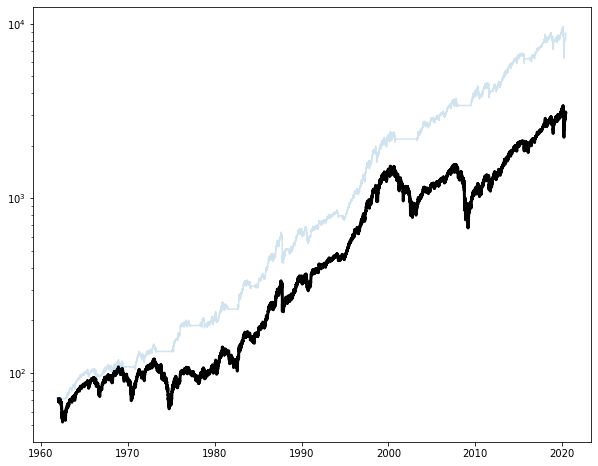

In [37]:
best4data = run_sim(sp, sd, best4window, best4params, best4data, best4yet, specified=specified)

% in now: 0.9487081982629744
Actions taken: 611


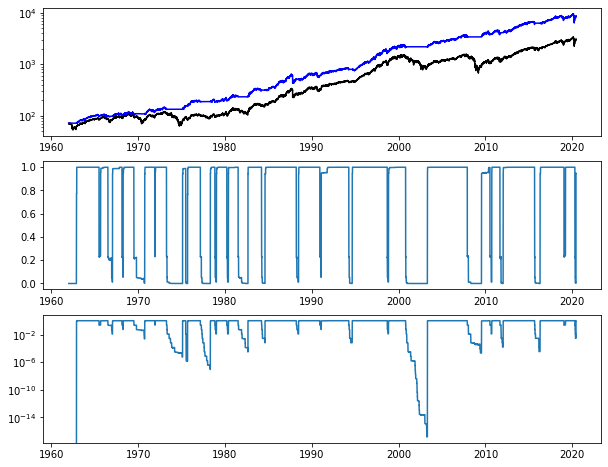

In [38]:
plot_results(best4data)

% in now: 0.9487081982629744
Actions taken: 7


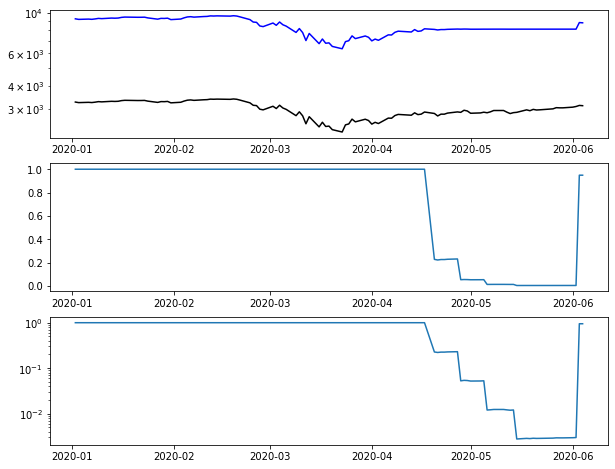

In [39]:
plot_results(best4data, '2020-01-01')

# 3-Deviations  (401(k))


```
1: Final value: $ 7523.59 (window = 199; sd = 0.192)
New best model!
window: 199
params:
{'amounts': [-0.2024510436231465, -0.6569017554369292, 0.9735421462755409],
 'qs': [0.16472873807928215, 0.9862260934882866, 0.4541267737411986]}
```

In [40]:
DEFAULT3PARAMS = {'qs':      [-0.4, 0.5, 0.6],
                  'amounts': [   0,   0,   0]}

In [41]:
BEST3YET = 7523.59 * 0.95
BEST3PARAMS = {'amounts': [-0.2024510436231465, -0.6569017554369292, 0.9735421462755409],
 'qs': [0.16472873807928215, 0.9862260934882866, 0.4541267737411986]}
#BEST3PARAMS = DEFAULT3PARAMS
BEST3WINDOW = 199

In [42]:
best3yet = BEST3YET
best3params = BEST3PARAMS
best3window = BEST3WINDOW

In [43]:
sd = 0.018
specified = None
#specified = {'window': True, 'amounts': [], 'qs': []} # ~2
#specified = {'window': False, 'amounts': [], 'qs': [2]} # ~2

 1: Final value: $ 7556.13 (window = 199; sd = 0.018)
New best model!
window: 199
params:
{'amounts': [-0.2024510436231465, -0.6569017554369292, 0.9735421462755409],
 'qs': [0.16472873807928215, 0.9862260934882866, 0.4541267737411986]}


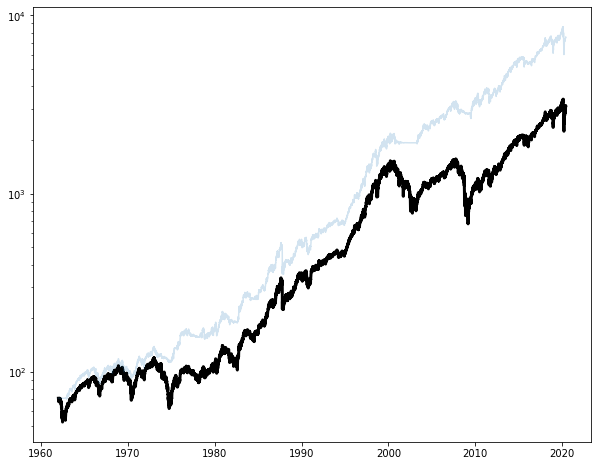

In [44]:
best3data = run_sim(sp, sd, best3window, best3params, best3data, best3yet, specified=specified)

% in now: 0.42501685322400407
Actions taken: 410


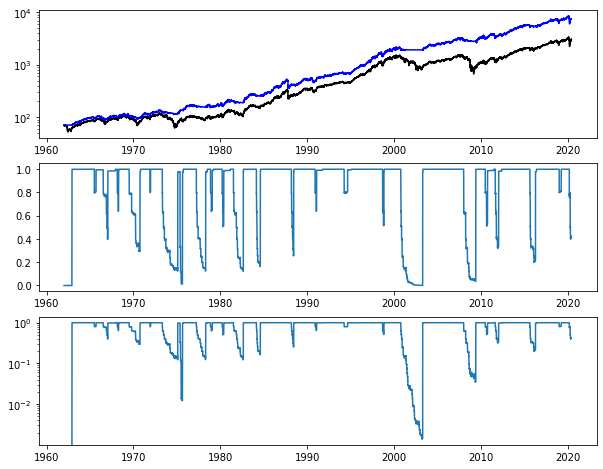

In [45]:
plot_results(best3data)

% in now: 0.42501685322400407
Actions taken: 4


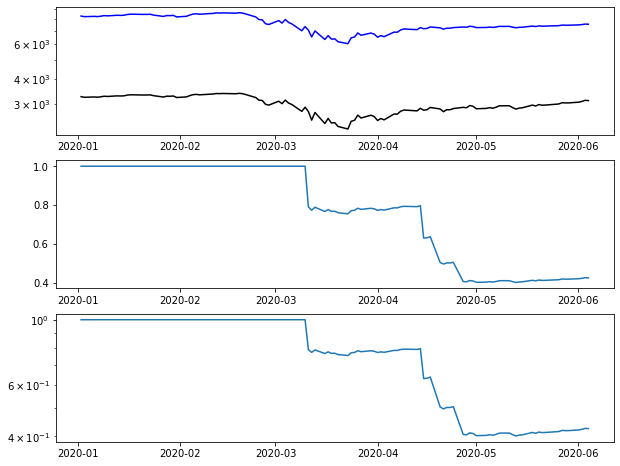

In [46]:
plot_results(best3data, '2020-01-01')

# 2-Deviations

```
37: Final value: $ 7350.48 (window = 226; sd = 0.007)
New best model!
window: 226
params:
{'amounts': [0.99, -0.7049597425909176],
 'qs': [0.35250237242263466, 0.18586877986754852]}
 ```        

In [47]:
DEFAULT2PARAMS = {'qs':      [0.5, -0.5],
                  'amounts': [  0,    0]}

In [48]:
BEST2YET =  8011.16 * 0.95
BEST2PARAMS = {'amounts': [0.99, -0.7049597425909176],
 'qs': [0.35250237242263466, 0.18586877986754852]}
#BEST2PARAMS = DEFAULT2PARAMS
BEST2WINDOW = 226

In [49]:
best2yet = BEST2YET
best2params = BEST2PARAMS
best2window = BEST2WINDOW

In [50]:
sd = 0.002
specified = None
#specified = {'window': True, 'amounts': [], 'qs': []} # ~1
#specified = {'window': False, 'amounts': [], 'qs': [1]} # ~1

 1: Final value: $ 7984.42 (window = 226; sd = 0.002)
New best model!
window: 226
params:
{'amounts': [0.99, -0.7049597425909176],
 'qs': [0.35250237242263466, 0.18586877986754852]}


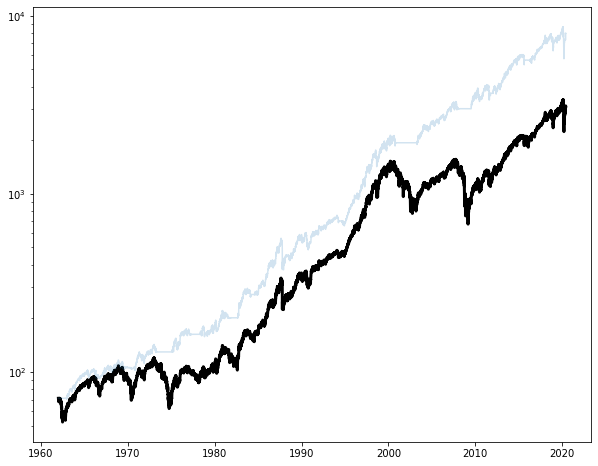

In [51]:
best2data = run_sim(sp, sd, best2window, best2params, best2data, best2yet, specified=specified)

% in now: 0.9908690415308886
Actions taken: 318


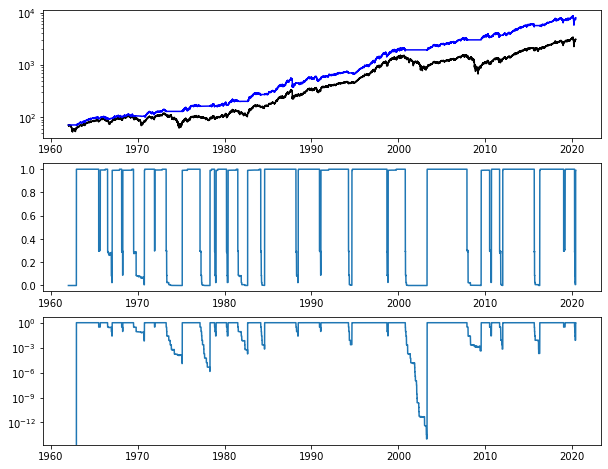

In [52]:
plot_results(best2data)

% in now: 0.9908690415308886
Actions taken: 88


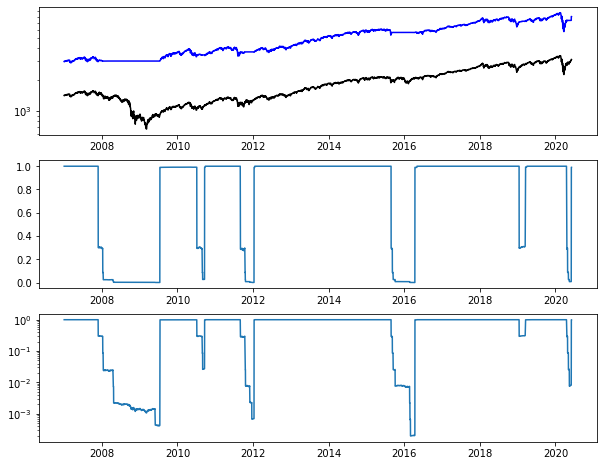

In [53]:
plot_results(best2data, '2007-01-01')

% in now: 0.9908690415308886
Actions taken: 6


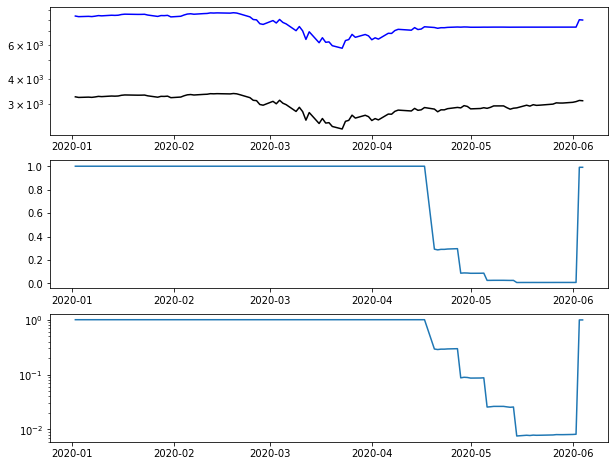

In [54]:
plot_results(best2data, '2020-01-01')

In [55]:
RUN += 1

In [56]:
!say well, that was one heck of a ride